In [1]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from keras.layers import LSTM, Dense, Conv1D, TimeDistributed, Flatten, Activation, Dropout, Bidirectional
from keras.callbacks import History, TensorBoard, Callback
import keras.initializers as KI
from keras.layers import BatchNormalization
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

2023-07-13 16:10:17.588968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jai/miniconda3/envs/dl/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

#merge the gaze labelled data for each participant and document
gaze_path = "../../data/working/gaze_labelled/"

gaze_list = [pd.read_csv(data, index_col=0) for data in sorted(glob.glob(gaze_path + "/*/*"))]
gaze_data = pd.concat(gaze_list, ignore_index=True, sort=False)

In [3]:
gaze_data.columns
features = ['left_gaze_x', 'left_gaze_y',
       'left_position_x', 'left_position_y', 'left_position_z', 'left_pupil',
       'right_gaze_x', 'right_gaze_y', 'right_position_x', 'right_position_y',
       'right_position_z', 'right_pupil','interest']

# features = ['left_gaze_x', 'left_gaze_y', 'left_pupil',
#        'right_gaze_x', 'right_gaze_y', 'right_pupil','understand','interest']

gaze_data = gaze_data[(gaze_data['document'] != 'd20') & (gaze_data['document'] != 'd06')]
#gaze_data = gaze_data[(gaze_data['participant'] != 'p01') & (gaze_data['document'] != 'd16') ]
participants = gaze_data.participant.unique()
documents = gaze_data.document.unique()


In [4]:
gaze_data.participant.unique()

array(['p01', 'p02', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11',
       'p12', 'p13', 'p14', 'p15'], dtype=object)

In [5]:
# conditions = [
#     (gaze_data['interest'] <=2 ),
#     (gaze_data['interest'] > 2)]

# class_values = [0,1]
# gaze_data['Interest'] = np.select(conditions, class_values)

In [6]:
gaze_data['interest'] = gaze_data['interest'].replace([1,2,3,4], [0,1,2,3])
gaze_data['understand'] = gaze_data['understand'].replace([1,2,3,4], [0,1,2,3])

In [7]:
gaze_data.interest.unique()

array([1., 2., 3., 0.])

In [8]:
def normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

def get_frames(df, frame_size, step_size, label_name, Binary=False):

    N_FEATURES = len(features) - 1

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, step_size):
        for column in df.columns:
            if column!=label_name:
                column = df[column].values[i: i + frame_size]
                frames.append([column])
        else:
            
        # Retrieve the most often used label in this segment
            label = stats.mode(df[label_name][i: i + frame_size])[0][0]
            if Binary:
                if(label == 0) | (label == 1):
                    label = 0
                    labels.append(label)
                else:
                    label = 1
                    labels.append(label)
            else:

                labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [9]:
samp_freq = 60
frame_size = samp_freq * 30
step_size = samp_freq * 15

def prepare_data(data, p_fold):

    df_train = data[data['participant'] != participants[p_fold]]
    df_val = data[data['participant'] == participants[p_fold]]

    # df_train = data[data['document'] != documents[d_fold]]
    # df_val = data[data['document'] == documents[d_fold]]
    
    # df_train.drop(['participant','document'], axis=1, inplace=True)
    # df_val.drop(['participant','document'], axis=1, inplace=True)

    df_train = df_train[features]
    df_val = df_val[features]
    
    for col in df_train.columns:
        
        if col != 'interest':        
            df_train[col] = normalize(df_train[col])
            df_val[col] = normalize(df_val[col])

    x_train, y_train = get_frames(df_train, frame_size, step_size, 'interest')
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    num_classes = 4
    print (x_train.shape, y_train.shape)

    input_shape = (num_time_periods * num_sensors)
    x_train = x_train.reshape(x_train.shape[0], input_shape)

    # x_train = x_train.astype("float32")
    # y_train = y_train.astype("float32")

    #y_train = np_utils.to_categorical(y_train, num_classes)
    print(y_train.shape)

    x_val, y_val = get_frames(df_val, frame_size, step_size, 'interest')

    num_time_periods1, num_sensors1 = x_val.shape[1], x_val.shape[2]

    input_shape1 = (num_time_periods1 * num_sensors1)
    x_val = x_val.reshape(x_val.shape[0], input_shape1)

    # x_val = x_val.astype("float32")
    # y_val = y_val.astype("float32")

    #y_val = np_utils.to_categorical(y_val, num_classes)

    return num_time_periods, num_sensors, x_train, x_val, y_train, y_val


In [10]:
# Hyper-parameters
BATCH_SIZE = 128
EPOCHS = 10

In [13]:
conf_matrix_list_of_arrays = []
scores = []
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
prec_per_fold = []
rec_per_fold = []

def build_model(num_time_periods, num_sensors, num_classes, input_shape):
  # 1D CNN neural network
    
    model = Sequential()
    model.add(Reshape((frame_size, num_sensors), input_shape=(input_shape,)))
    model.add(Conv1D(200, 3, activation='relu', input_shape=(frame_size, num_sensors)))
    model.add(Conv1D(100, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(50, 10, activation='relu'))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(15, 2, activation='relu'))
    #model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

    # model = Sequential()
    # model.add(Reshape((frame_size, num_sensors), input_shape=(input_shape,)))
    # model.add(Conv1D(filters = 32,kernel_size = 3,strides=1,padding='same',input_shape=(frame_size, num_sensors)))	
    # model.add(BatchNormalization())
    # model.add(Activation('elu'))
    # model.add(MaxPooling1D(pool_size = 4, strides = 4))

    # model.add(Conv1D(filters=16, kernel_size = 3, strides=1,padding='same'))
    # model.add(BatchNormalization())
    # model.add(Activation('elu'))
    # model.add(MaxPooling1D(pool_size = 4, strides = 4))

    # model.add(Conv1D(filters=32, kernel_size = 3, strides=1,padding='same'))
    # model.add(BatchNormalization())
    # model.add(Activation('elu'))
    # model.add(MaxPooling1D(pool_size = 4, strides = 4))

    # model.add(Conv1D(filters=8, kernel_size = 3, strides=1,padding='same'))
    # model.add(BatchNormalization())
    # model.add(Activation('elu'))
    # model.add(MaxPooling1D(pool_size = 4, strides = 4))

    # #LSTM
    # #model.add(LSTM(32))
    # #model.add(LSTM(16))
        
    # model.add(Dense(num_classes,activation='softmax'))

    # #Model compilation	
    # opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    # model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    

def evaluate(num_time_periods, num_sensors,t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE):
    
    input_shape = (num_time_periods * num_sensors)
    #model = None
    model = build_model(num_time_periods, num_sensors, 4, input_shape)
    #model = build_model(4, frame_size, num_time_periods,)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    # results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], 
    #           verbose=1, validation_data=(val_x,val_y))  
    
    # val_score = model.evaluate(val_x, val_y)
    #preds = model.predict(val_x)

    history = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1, validation_split=0.3)
    scores = model.evaluate(val_x, val_y)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    
    
    y_pred = np.argmax(model.predict(val_x), axis=-1)
    f1_per_fold.append(f1_score(val_y, y_pred, average='weighted'))
    prec_per_fold.append(precision_score(val_y, y_pred, average='weighted'))
    rec_per_fold.append(recall_score(val_y, y_pred, average='weighted'))
    print('F1 score : ', f1_score(val_y, y_pred, average='weighted'))

    # pd.DataFrame(history.history).plot(figsize=(8, 5))
    # plt.show()

    cm = confusion_matrix(val_y, y_pred, labels=[0,1,2,3])
    print('Confusion Matrix : ')
    print(cm)
    
    #conf_matrix_list_of_arrays.append(cm)
    return history, scores, y_pred, acc_per_fold, f1_per_fold

def plot_cmx(labels, predicteds, binary=False):
    cmx = confusion_matrix(labels, predicteds)
    cmx = cmx.astype('float') / cmx.sum(axis=1)[:, np.newaxis]
    if binary:
        class_names = ['not-interested', 'interested']
    else:
        class_names = ['1','2','3','4']
    plt.figure(figsize=(8, 6))
    plt.title("mean accuracy: %.2f" % accuracy_score(labels, predicteds))
    sns.heatmap(cmx, annot=True, fmt=".0%",center=1, xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()


In [14]:
model_history = [] 
cvscores = []
predicted = []
labels = []

for i in range(len(participants)):
    
    pred = []
    label = []
    print("Training with participants " +  participants[i] + " left out")
    num_time_periods, num_sensors, t_x, val_x, t_y, val_y = prepare_data(gaze_data, i)
    results, scores, preds, acc, f1 = evaluate(num_time_periods, num_sensors,t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE)
    model_history.append(results)
    cvscores.append(scores[1] * 100)
    #pred.extend(preds)
    predicted.extend(preds)
    label.extend(val_y)
    labels.extend(label) 
    #pred=np.argmax(pred, axis=1)
    #label=np.argmax(label, axis=1)
    #plot_cmx(label,pred,binary=True)
    print("Accuracy with document " + participants[i] + ' as test :'+str(scores[1]*100))
    print("======="*12, end="\n\n\n")

#predicted = np.argmax(predicted, axis=1)
plot_cmx(labels, predicted)
print ('Average accuracy with all the documents')


Training with participants p01 left out
(2786, 1800, 12) (2786,)
(2786,)
Epoch 1/10


2023-07-13 16:16:03.005900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.3215

2023-07-13 16:16:19.398655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 18s 496ms/step - loss: 1.3831 - accuracy: 0.3215 - val_loss: 1.4914 - val_accuracy: 0.2201
Epoch 2/10
16/16 [==============================] - 4s 243ms/step - loss: 1.2669 - accuracy: 0.4082 - val_loss: 1.5427 - val_accuracy: 0.2476
Epoch 3/10
16/16 [==============================] - 4s 246ms/step - loss: 1.2079 - accuracy: 0.4585 - val_loss: 1.6554 - val_accuracy: 0.2428
Epoch 4/10
16/16 [==============================] - 4s 231ms/step - loss: 1.1246 - accuracy: 0.5174 - val_loss: 1.6988 - val_accuracy: 0.2213
Epoch 5/10
16/16 [==============================] - 4s 245ms/step - loss: 1.1142 - accuracy: 0.5318 - val_loss: 1.7024 - val_accuracy: 0.2428
Epoch 6/10
16/16 [==============================] - 4s 244ms/step - loss: 0.9849 - accuracy: 0.5933 - val_loss: 1.9416 - val_accuracy: 0.2512
Epoch 7/10
16/16 [==============================] - 4s 232ms/step - loss: 0.8714 - accuracy: 0.6236 - val_loss: 2.0869 - val_accuracy: 0.2536
Epoch 8/10
16/16

2023-07-13 16:16:55.035211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 42ms/step
F1 score :  0.2120011454573252
Confusion Matrix : 
[[ 0  0  0  0]
 [ 7  2 11 21]
 [ 8 21 22 90]
 [ 2  0  0 17]]
Accuracy with document p01 as test :20.398010313510895


Training with participants p02 left out
(2664, 1800, 12) (2664,)
(2664,)
Epoch 1/10


2023-07-13 16:16:59.102313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 1.3734 - accuracy: 0.3718

2023-07-13 16:17:04.792427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 7s 328ms/step - loss: 1.3734 - accuracy: 0.3718 - val_loss: 1.5368 - val_accuracy: 0.2175
Epoch 2/10
15/15 [==============================] - 3s 229ms/step - loss: 1.2075 - accuracy: 0.4592 - val_loss: 1.7371 - val_accuracy: 0.1963
Epoch 3/10
15/15 [==============================] - 3s 225ms/step - loss: 1.1302 - accuracy: 0.4946 - val_loss: 1.6182 - val_accuracy: 0.2612
Epoch 4/10
15/15 [==============================] - 3s 225ms/step - loss: 1.0139 - accuracy: 0.5520 - val_loss: 1.8849 - val_accuracy: 0.2425
Epoch 5/10
 4/15 [=======>......................] - ETA: 2s - loss: 0.8655 - accuracy: 0.6348

KeyboardInterrupt: 

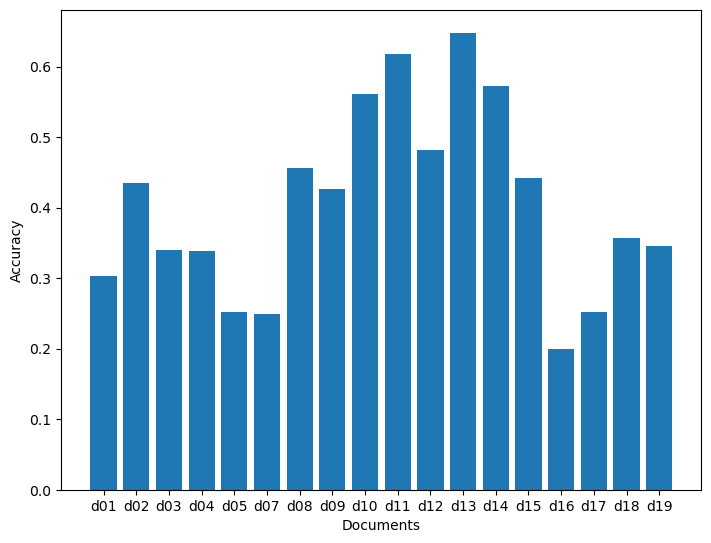

In [145]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(documents,acc)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Documents')
plt.show()

In [32]:
per_acc = []; per_f1 = []; per_pred = []; per_lab = []
for p in participants:

    df = gaze_data[gaze_data['participant'] == p]
    feat = ['left_gaze_x', 'left_gaze_y',
        'left_position_x', 'left_position_y', 'left_position_z', 'left_pupil',
        'right_gaze_x', 'right_gaze_y', 'right_position_x', 'right_position_y',
        'right_position_z', 'right_pupil','interest']


    X, y = get_frames(df[feat], frame_size, step_size,'interest')
    X = normalize(X)

    kfold = KFold(n_splits=10, shuffle=True, random_state=49)
    fold_no = 1

    for train_index, test_index in kfold.split(X,y):

        X_train, X_test, y_train, y_test = (X[train_index], 
                                            X[test_index], 
                                            y[train_index], 
                                            y[test_index])

        
        results, scores, preds, acc, f1 = evaluate(X_train.shape[1], X_train.shape[2], X_train, X_test, y_train, y_test, EPOCHS, BATCH_SIZE)
    
        per_pred.extend(preds)
        per_lab.extend(y_test)
    
    per_acc.append(np.mean(acc))
    per_f1.append(np.mean(f1))



Epoch 1/10
3/3 [==============================] - 2s 401ms/step - loss: 1.1982 - accuracy: 0.4526 - val_loss: 0.3587 - val_accuracy: 0.9573
Epoch 2/10
3/3 [==============================] - 1s 309ms/step - loss: 0.7346 - accuracy: 0.6842 - val_loss: 0.2277 - val_accuracy: 0.9817
Epoch 3/10
3/3 [==============================] - 1s 309ms/step - loss: 0.6599 - accuracy: 0.6895 - val_loss: 0.3168 - val_accuracy: 0.9329
Epoch 4/10
3/3 [==============================] - 1s 308ms/step - loss: 0.5127 - accuracy: 0.7789 - val_loss: 0.3014 - val_accuracy: 0.8902
Epoch 5/10
3/3 [==============================] - 1s 308ms/step - loss: 0.4488 - accuracy: 0.8026 - val_loss: 0.4854 - val_accuracy: 0.8232
Epoch 6/10
3/3 [==============================] - 1s 313ms/step - loss: 0.3940 - accuracy: 0.8000 - val_loss: 0.5054 - val_accuracy: 0.8598
Epoch 7/10
3/3 [==============================] - 1s 333ms/step - loss: 0.3198 - accuracy: 0.8711 - val_loss: 0.9116 - val_accuracy: 0.7500
Epoch 8/10
3/3 [====

In [1]:
np.mean(per_acc)

NameError: name 'np' is not defined

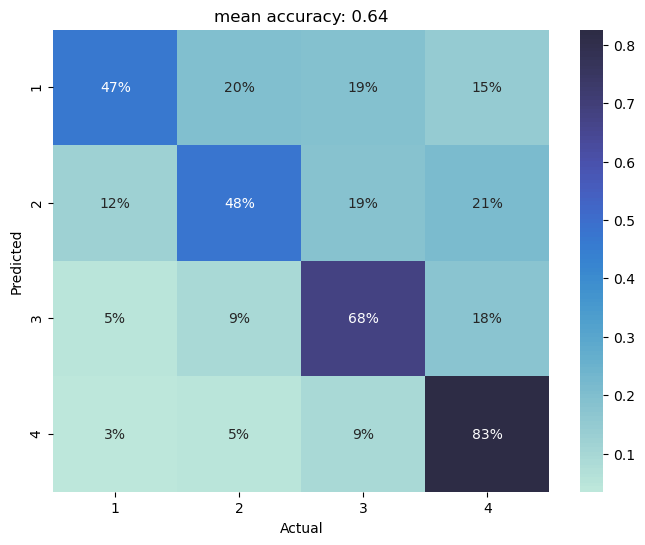

In [34]:
plot_cmx(per_lab, per_pred)

results

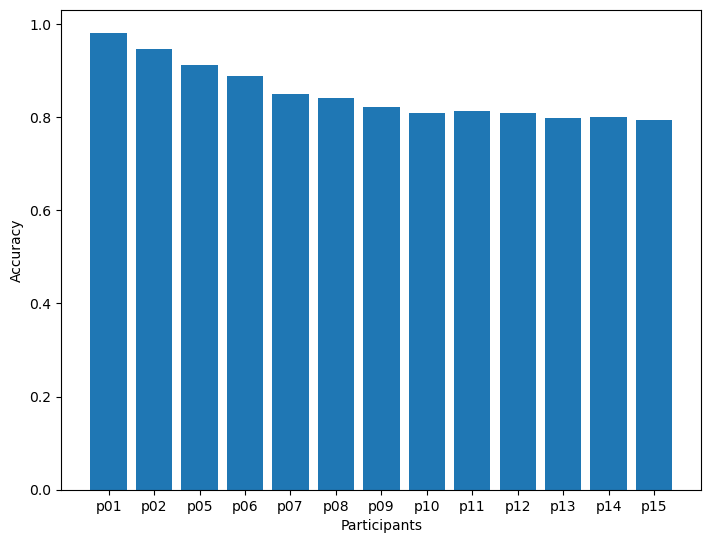

In [89]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(participants,per_acc)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Participants')
plt.show()

In [12]:
acc_part_ind = [0.36480000615119934,0.462184876203537,0.24163569509983063,0.47557002305984497,
 0.37142857909202576,0.3857566714286804,0.35477766394615173,0.3710407316684723,0.43250688910484314,
 0.38634321093559265,0.5161290168762207,0.38623103499412537,0.33213645219802856]

per_acc = [0.9818032741546631,0.9463757554690043,0.9127473786473275,0.8891979014873505,0.8492125362157822,0.8419753040586199,
 0.821847053617239,0.8097149617142148,0.812524351477623,0.8088041896169836,0.7990932355324427,0.801342386007309,0.7944243443863732]

In [17]:
part = ["p"+str(x).zfill(2) for x in range(1, 14)]
accuracies = list(zip(part,acc_part_ind,per_acc))
df_acc = pd.DataFrame(accuracies, columns = ['Participants', 'Person-Independent','Person-Dependent'])

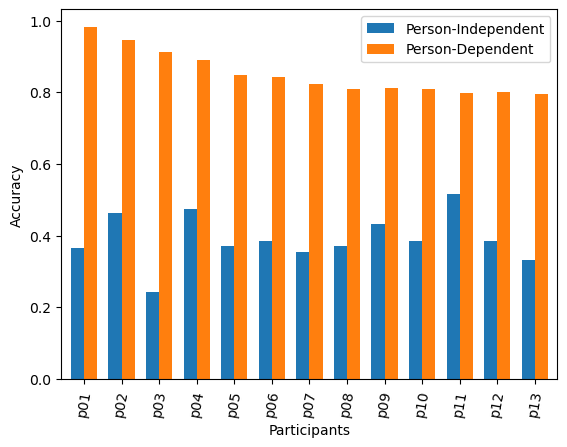

In [18]:
df_acc.plot.bar(x = 'Participants', y = ['Person-Independent','Person-Dependent'], rot = 80, width=0.7)
#plt.title("Accuracies per subject")
plt.ylabel('Accuracy')
plt.savefig("/Users/jai/Documents/IEEE-Interest/plots/acc_per_participants.pdf", bbox_inches='tight')


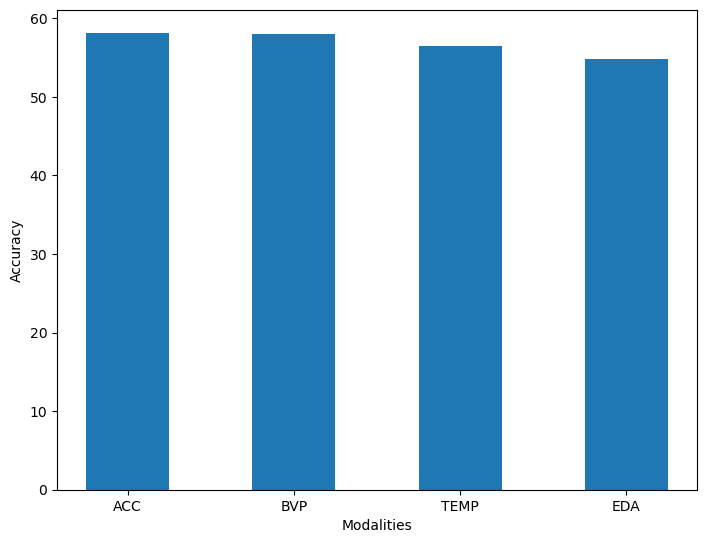

In [63]:
modalities = ['ACC','BVP','TEMP','EDA']
acc = [58.17,58.03, 56.41, 54.75]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(modalities,acc, width=0.5)

# for i, v in enumerate(acc):
#     ax.text(v + 5, i + .25, str(v), color='black',va='center' ,fontweight='bold')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Modalities')
plt.show()

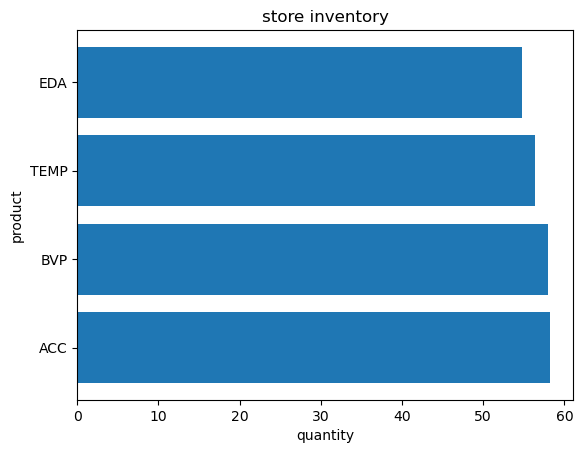

In [65]:

plt.barh(modalities, acc)
plt.title('store inventory')
plt.ylabel('product')
plt.xlabel('quantity')
plt.show()